**Task 1.1 - 1.3**

Training on Dataset B: Linux Kernel Code

In [ ]:
# Setting up Imports and Reproducibility:

import os, re, random, collections, math
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.manifold import TSNE

import pickle
import json

# Setting device and seeds for reproducibility
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)
seed = 1337
random.seed(seed); np.random.seed(seed); torch.manual_seed(seed)
if device.type == 'cuda': torch.cuda.manual_seed_all(seed)


Device: cuda


In [ ]:
# Tokenization and Vocabulary Building:

PAD_TOKEN = "<PAD>"
UNK_TOKEN = "<UNK>"

def tokenize_code(text):
    # improved C/C++-aware tokenizer: preserves strings, comments, identifiers, numbers, operators
    token_pattern = r"""
        (\"(?:\\.|[^\"\\]

)*\")       |   # double-quoted strings
        ('(?:\\.|[^'\\]

)*')          |   # single-quoted char literals
        (//[^\n]*|/\*[\s\S]*?\*/)    |   # single-line and multi-line comments
        (\b[_A-Za-z][_A-Za-z0-9]*\b) |   # identifiers
        (\d+\.\d+|\d+)               |   # numbers (ints and floats)
        (==|!=|<=|>=|->|<<|>>|&&|\|\||[-+*/%<>]=?|[:;,\.\(\)

\[\]

\{\}=~!&\|\^<>])  # operators and punctuation
    """
    tokens = re.findall(token_pattern, text, flags=re.VERBOSE)
    flat = [t for tup in tokens for t in tup if t]
    return flat

# Vocabulary Building and Data Preparation:
def build_vocab(tokens, min_freq=1, max_vocab=None):
    freq = collections.Counter(tokens)
    items = [w for w,c in freq.most_common() if c>=min_freq]
    if max_vocab: items = items[:max_vocab]
    itos = [PAD_TOKEN, UNK_TOKEN] + items
    stoi = {w:i for i,w in enumerate(itos)}
    return stoi, itos, freq

# Token to ID Conversion and Sliding Context Window:
def tokens_to_ids(tokens, stoi):
    return [stoi.get(t, stoi[UNK_TOKEN]) for t in tokens]

# Sliding context window:
def sliding_context(tokens_ids, block_size):
    X, Y = [], []
    context = [0]*block_size
    for tid in tokens_ids:
        X.append(context.copy()); Y.append(tid)
        context = context[1:] + [tid]
    return np.array(X, dtype=np.int64), np.array(Y, dtype=np.int64)


In [ ]:
# Vocabulary and Data Preparation on Linux Kernel Code:

fname = "linux kernel code.txt"
assert os.path.exists(fname), f"Upload {fname} before running"

with open(fname, 'r', encoding='utf-8', errors='ignore') as f:
    raw = f.read()

tokens = tokenize_code(raw)

# optional sampling for quick runs
SAMPLE_LIMIT = None
if SAMPLE_LIMIT is not None:
    tokens = tokens[:SAMPLE_LIMIT]

stoi, itos, freq = build_vocab(tokens, min_freq=1)
print("Tokens:", len(tokens))
print("Vocabulary size (with PAD/UNK):", len(itos))
print("Top 10 tokens:", freq.most_common(10))
least10 = sorted(freq.items(), key=lambda x:(x[1], x[0]))[:10]
print("Least 10 tokens:", least10)

# Preparing data for model training:
block_size = 10
ids = tokens_to_ids(tokens, stoi)
X, Y = sliding_context(ids, block_size)
print("X shape:", X.shape, "Y shape:", Y.shape)


Tokens: 1120789
Vocabulary size (with PAD/UNK): 43161
Top 10 tokens: [('\n', 201909), ('(', 78696), (')', 78696), (';', 77231), (',', 46286), ('->', 30309), ('=', 28508), ('*', 23212), ('{', 19115), ('}', 19114)]
Least 10 tokens: [('"\t\'%s\' cs_now: %llx cs_last: %llx mask: %llx\\n"', 1), ('"\t\'%s\' wd_now: %llx wd_last: %llx mask: %llx\\n"', 1), ('"                               local_irq_disable();\\n"', 1), ('"                       %s %s "', 1), ('"                 "', 1), ('"                "', 1), ('"               FUNCTION CALLS\\n"', 1), ('"               |   |   |   |\\n"', 1), ('"              events:    %ld\\n"', 1), ('"              |  "', 1)]
X shape: (1120789, 10) Y shape: (1120789,)


In [ ]:
# Dataset and Model Definition:
class WordDataset(torch.utils.data.Dataset):
    def __init__(self, X, Y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.Y = torch.tensor(Y, dtype=torch.long)
    def __len__(self): return len(self.X)
    def __getitem__(self, idx): return self.X[idx], self.Y[idx]
    
# Model Definition
class NextWordMLP(nn.Module):
    def __init__(self, block_size, vocab_size, emb_dim=64, hidden_sizes=[1024,1024], activation='tanh'):
        super().__init__()
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)
        in_dim = block_size * emb_dim
        layers = []
        for hs in hidden_sizes:
            layers.append(nn.Linear(in_dim, hs))
            layers.append(nn.Tanh() if activation=='tanh' else nn.ReLU())
            in_dim = hs
        self.mlp = nn.Sequential(*layers)
        self.head = nn.Linear(in_dim, vocab_size)
        
    def forward(self, x):
        e = self.emb(x).view(x.size(0), -1)
        h = self.mlp(e)
        return self.head(h)


In [ ]:
# Training and Evaluation Functions:
def train_model(X, Y, itos, block_size, emb_dim, activation,
                batch_size=80000, epochs=200, lr=1e-3, val_frac=0.1):
    ds = WordDataset(X, Y)
    n_val = int(len(ds) * val_frac)
    train_ds, val_ds = random_split(ds, [len(ds)-n_val, n_val])
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size)

    model = NextWordMLP(block_size, len(itos), emb_dim=emb_dim,
                        hidden_sizes=[1024,1024], activation=activation).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr)
    loss_fn = nn.CrossEntropyLoss()

    history = {'train_loss': [], 'val_loss': []}
    for ep in range(1, epochs+1):
        model.train(); total, count = 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            loss = loss_fn(model(xb), yb)
            opt.zero_grad(); loss.backward(); opt.step()
            total += loss.item() * xb.size(0); count += xb.size(0)
        train_loss = total / count

        model.eval(); val_total, val_count = 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                val_total += loss_fn(model(xb), yb).item() * xb.size(0)
                val_count += xb.size(0)
        val_loss = val_total / val_count
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        if ep % 10 == 0 or ep <= 3:
            print(f"Epoch {ep}/{epochs} - Train {train_loss:.4f} | Val {val_loss:.4f}")

    return model, history

# Evaluation Function:
def compute_accuracy(model, X, Y):
    ds = WordDataset(X, Y)
    loader = DataLoader(ds, batch_size=512)
    correct, total = 0, 0
    model.eval()
    with torch.no_grad():
        for xb, yb in loader:
            xb, yb = xb.to(device), yb.to(device)
            preds = model(xb).argmax(dim=-1)
            correct += (preds == yb).sum().item()
            total += yb.numel()
    return correct / total


In [ ]:
# Code Generation and t-SNE Visualization:

def generate_from_prompt(model, itos, stoi, prompt, block_size=10, max_tokens=30, temp=1.0):
    model.eval()
    toks = tokenize_code(prompt)
    ids = [stoi.get(t, stoi[UNK_TOKEN]) for t in toks]
    context = [0]*max(0, block_size - len(ids)) + ids[-block_size:]
    out = toks.copy()
    with torch.no_grad():
        for _ in range(max_tokens):
            x = torch.tensor([context], dtype=torch.long).to(device)
            logits = model(x)[0] / temp
            probs = F.softmax(logits, dim=-1).cpu().numpy()
            idx = np.random.choice(len(probs), p=probs)
            token = itos[idx]
            if token == PAD_TOKEN: break
            out.append(token)
            context = context[1:] + [idx]
    return " ".join(out)

# t-SNE Visualization Function:
def plot_tsne_for_model(model, itos, select_tokens=None, title='t-SNE Embeddings', perplexity=30):
    emb = model.emb.weight.detach().cpu().numpy()
    if emb.shape[0] > 5000:
        emb = emb[:2000]; labels = itos[:2000]
    else:
        labels = itos
    print("Running t-SNE on", len(labels), "tokens...")
    tsne = TSNE(n_components=2, random_state=seed, perplexity=min(perplexity, 50))
    emb2 = tsne.fit_transform(emb)
    plt.figure(figsize=(10,8))
    plt.scatter(emb2[:,0], emb2[:,1], s=6, alpha=0.6)
    if select_tokens is None:
        for i in range(2, min(102, len(labels))): plt.text(emb2[i,0], emb2[i,1], labels[i], fontsize=8)
    else:
        for tok in select_tokens:
            if tok in labels:
                i = labels.index(tok)
                plt.text(emb2[i,0], emb2[i,1], labels[i], fontsize=10, color='red')
    plt.title(title); plt.show()


Total configurations: 8

[1/8] Training emb_dim=32, activation=relu, block_size=3
Epoch 1/500 - Train 6.7374 | Val 4.8358
Epoch 2/500 - Train 4.5395 | Val 4.3053
Epoch 3/500 - Train 4.0787 | Val 3.9864
Epoch 10/500 - Train 2.9591 | Val 3.3273
Epoch 20/500 - Train 2.4341 | Val 3.2211
Epoch 30/500 - Train 2.1741 | Val 3.2235
Epoch 40/500 - Train 2.0096 | Val 3.2432
Epoch 50/500 - Train 1.8930 | Val 3.2635
Epoch 60/500 - Train 1.8034 | Val 3.2836
Epoch 70/500 - Train 1.7274 | Val 3.3116
Epoch 80/500 - Train 1.6683 | Val 3.3382
Epoch 90/500 - Train 1.6166 | Val 3.3633
Epoch 100/500 - Train 1.5757 | Val 3.3903
Epoch 110/500 - Train 1.5358 | Val 3.4102
Epoch 120/500 - Train 1.5037 | Val 3.4347
Epoch 130/500 - Train 1.4759 | Val 3.4535
Epoch 140/500 - Train 1.4532 | Val 3.4760
Epoch 150/500 - Train 1.4368 | Val 3.5004
Epoch 160/500 - Train 1.4190 | Val 3.5182
Epoch 170/500 - Train 1.4037 | Val 3.5298
Epoch 180/500 - Train 1.3913 | Val 3.5469
Epoch 190/500 - Train 1.3815 | Val 3.5651
Epoch 200

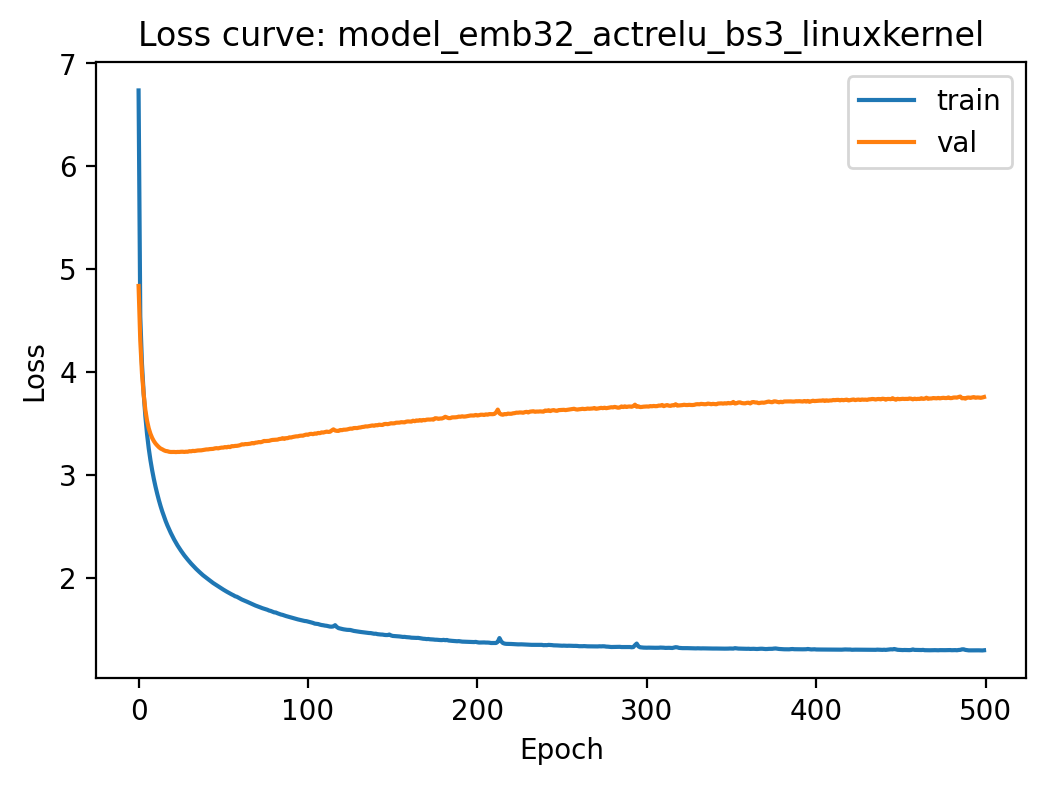

Training accuracy: 0.6879

Temperature 0.3:
static inline int 
 fetch_robust_entry ( compat_uptr_t * uentry , head ) ; 
 
 if ( ! ( trace_flags & TRACE_ITER_PRINTK ) ) 
 return - EINVAL ; 
 
 if ( ! ( trace_flags & TRACE_ITER_CONTEXT_INFO ) { 
 if (

Temperature 0.8:
static inline int hrtick_enabled ( struct rq * rq , struct task_struct * curr = current ; 
 
 if ( css_enable & ( 1 << 63 ) ) 
 continue ; 
 
 err = - EINVAL ; 
 
 retval =

Temperature 1.2:
static inline int same_magic ( const char * print_tainted ( ) , CAP_SYS_ADMIN ) ) { 
 perf_output_wakeup ( handle ) ; 
 sum = kstat_irqs ( irq ) ; 
 /* auid comparisons */ 
 void mutex_destroy ( void * data ) , 1 )
Running t-SNE on 2000 tokens...


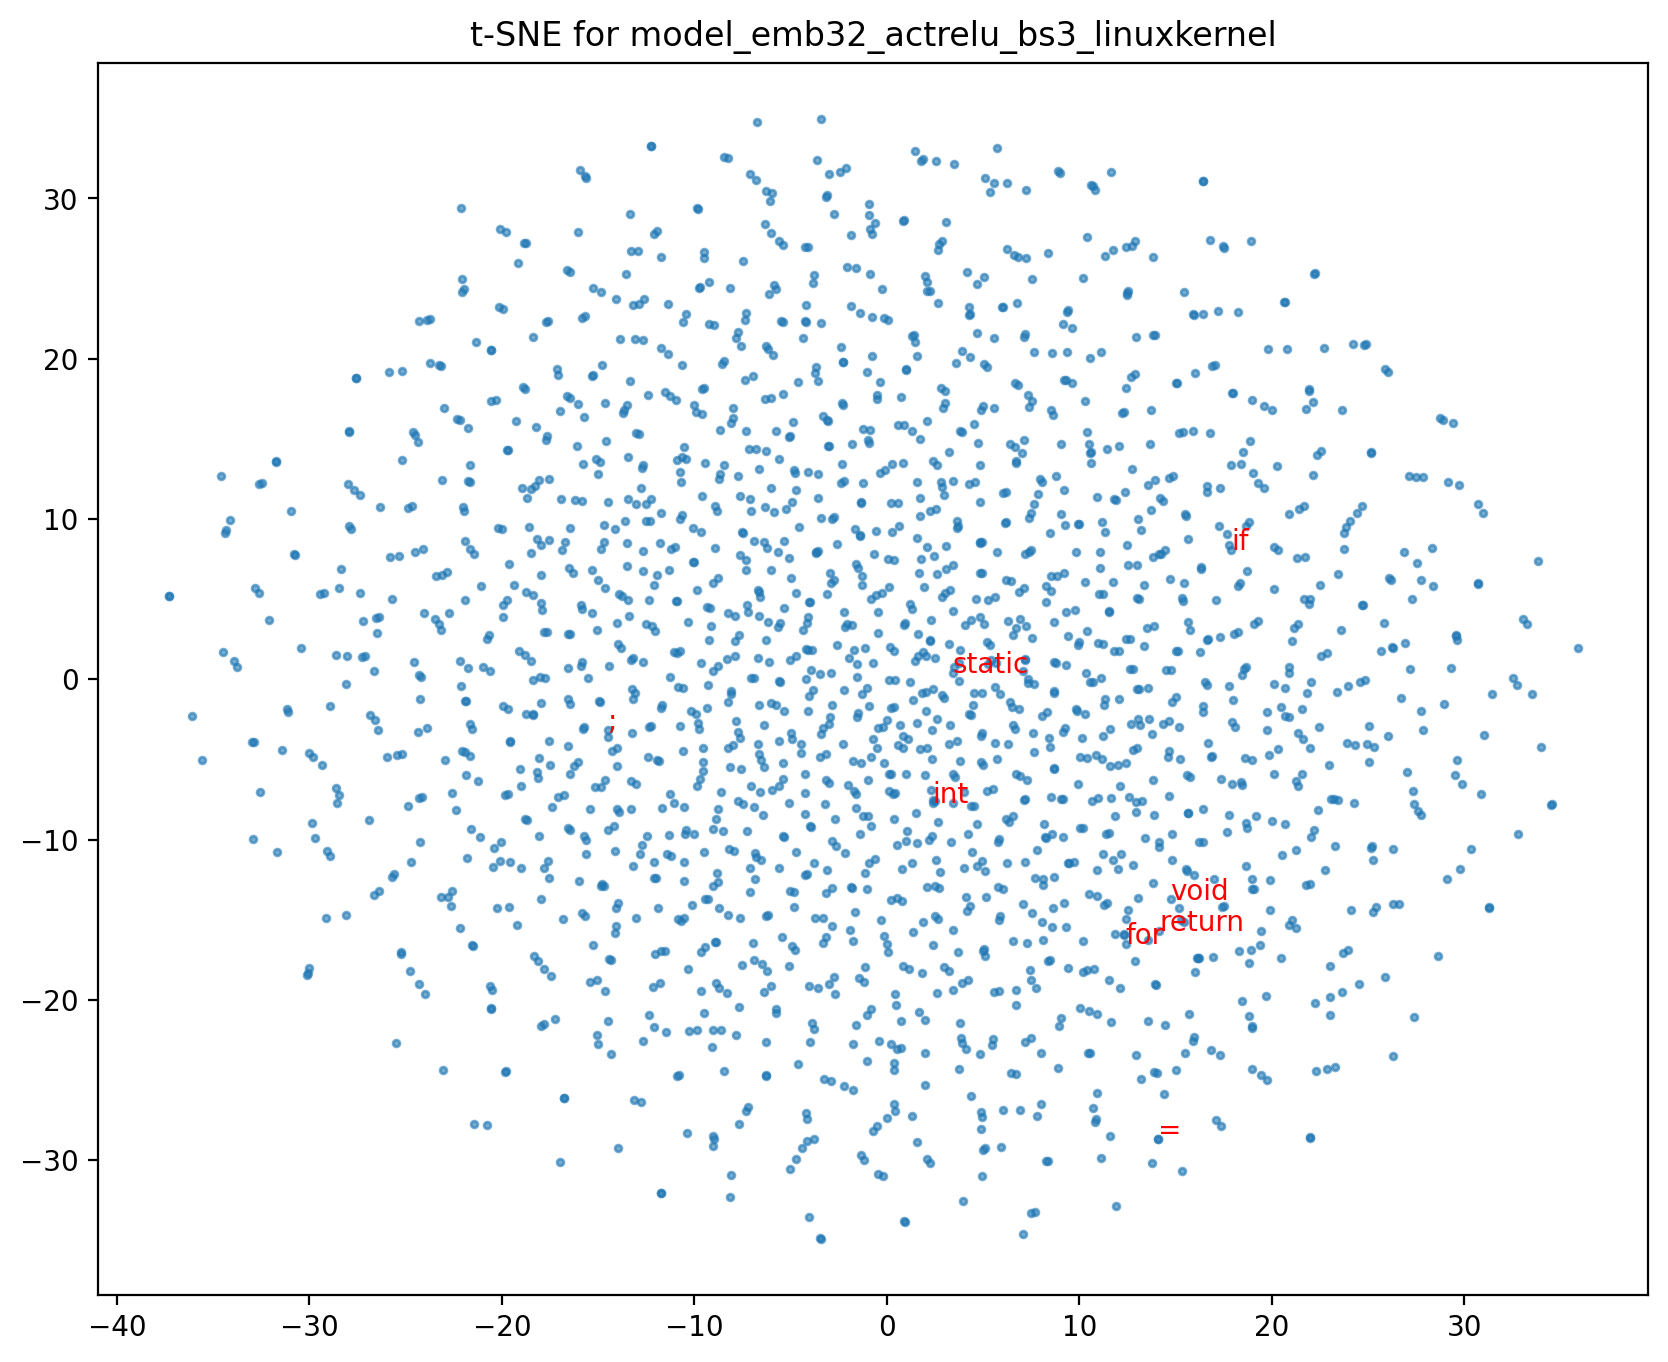


[2/8] Training emb_dim=32, activation=relu, block_size=5
Epoch 1/200 - Train 6.8581 | Val 5.0694
Epoch 2/200 - Train 4.7003 | Val 4.4582
Epoch 3/200 - Train 4.2216 | Val 4.1244
Epoch 10/200 - Train 2.9546 | Val 3.3057
Epoch 20/200 - Train 2.2253 | Val 3.1704
Epoch 30/200 - Train 1.8376 | Val 3.2198
Epoch 40/200 - Train 1.6035 | Val 3.2796
Epoch 50/200 - Train 1.4452 | Val 3.3483
Epoch 60/200 - Train 1.3254 | Val 3.3916
Epoch 70/200 - Train 1.2281 | Val 3.4559
Epoch 80/200 - Train 1.1481 | Val 3.4986
Epoch 90/200 - Train 1.0815 | Val 3.5709
Epoch 100/200 - Train 1.0235 | Val 3.6043
Epoch 110/200 - Train 0.9747 | Val 3.6671
Epoch 120/200 - Train 0.9307 | Val 3.6958
Epoch 130/200 - Train 0.8925 | Val 3.7540
Epoch 140/200 - Train 0.8617 | Val 3.7884
Epoch 150/200 - Train 0.8324 | Val 3.8314
Epoch 160/200 - Train 0.8052 | Val 3.8756
Epoch 170/200 - Train 0.7827 | Val 3.9109
Epoch 180/200 - Train 0.7657 | Val 3.9512
Epoch 190/200 - Train 0.7459 | Val 3.9868
Epoch 200/200 - Train 0.7303 | Va

In [ ]:
# Training combinations:
emb_dims = [32, 64]
activations = ['relu', 'tanh']
block_sizes = [3, 5]
hidden_sizes = [1024, 1024]

models_dir = Path("models")
models_dir.mkdir(exist_ok=True)


configs = [(e, a, b) for e in emb_dims for a in activations for b in block_sizes]
print(f"Total configurations: {len(configs)}")

first_done = False
for i, (emb_dim, activation, block_size) in enumerate(configs, start=1):
    print("\n" + "="*80)
    print(f"[{i}/{len(configs)}] Training emb_dim={emb_dim}, activation={activation}, block_size={block_size}")

    # preparing data
    X, Y = sliding_context(tokens_to_ids(tokens, stoi), block_size)

    # deciding epochs
    epochs = 500 if not first_done else 200
    model, hist = train_model(X, Y, itos, block_size, emb_dim, activation, epochs=epochs)
    first_done = True

    # saving files:
    
    model_name = f"model_emb{emb_dim}_act{activation}_bs{block_size}_linuxkernel"
    torch.save(model.state_dict(), f"{model_name}.pt")
    with open(f"{model_name}_vocab.pkl", "wb") as f: pickle.dump((stoi, itos), f)
    meta = {"block_size": block_size, "emb_dim": emb_dim, "hidden_sizes": hidden_sizes,
            "activation": activation, "epochs": epochs, "dataset": "linuxkernel"}
    with open(f"{model_name}.json", "w") as f: json.dump(meta, f, indent=4)
    print(f"Saved {model_name} files")

    # Doing complete visualisation for first model:
    
    if epochs == 500:
        plt.figure(figsize=(6,4))
        plt.plot(hist['train_loss'], label='train')
        plt.plot(hist['val_loss'], label='val')
        plt.xlabel("Epoch"); plt.ylabel("Loss")
        plt.title(f"Loss curve: {model_name}")
        plt.legend(); plt.show()

        acc = compute_accuracy(model, X, Y)
        print(f"Training accuracy: {acc:.4f}")

        for temp in [0.3, 0.8, 1.2]:
            print(f"\nTemperature {temp}:")
            print(generate_from_prompt(model, itos, stoi, "static inline int", block_size, 40, temp))

        select_tokens = ['int','return','if','for','static','void','=',';']
        plot_tsne_for_model(model, itos, select_tokens=select_tokens, title=f"t-SNE for {model_name}")